In [1]:
import pandas as pd
from google.colab import files
uploaded = files.upload()



Saving 2020-2024每日盤後資料.xlsx to 2020-2024每日盤後資料.xlsx
Saving HW1_DataExport.xlsx to HW1_DataExport.xlsx


In [2]:
import pandas as pd

# 載入資料
monthly_df = pd.read_excel("HW1_DataExport.xlsx")
daily_df = pd.read_excel("2020-2024每日盤後資料.xlsx")

# 時間與合約欄位處理
monthly_df['日期'] = pd.to_datetime(monthly_df['日期'])
monthly_df['成交量'] = pd.to_numeric(monthly_df['成交量(合計)'], errors='coerce')
daily_df['交易日期'] = pd.to_datetime(daily_df['交易日期'])
daily_df = daily_df[daily_df['交易時段'] == '盤後']
daily_df['合約代號'] = daily_df['契約'] + daily_df['到期月份(週別)'].astype(str)


In [3]:
# 用成交量前兩大合約定義近月與遠月
near = daily_df.groupby('交易日期').apply(lambda x: x.sort_values('成交量', ascending=False).iloc[0])
far = daily_df.groupby('交易日期').apply(lambda x: x.sort_values('成交量', ascending=False).iloc[1])

spread_df = pd.DataFrame({
    '交易日期': near['交易日期'],
    'near_close': near['收盤價'],
    'far_open': far['開盤價']
})
spread_df['diff'] = spread_df['near_close'] - spread_df['far_open']
spread_df['position'] = spread_df['diff'].apply(lambda x: 'bear' if x >= 0 else 'bull')

# 合併多空趨勢到每日資料
daily_df = daily_df.merge(spread_df[['交易日期', 'position']].reset_index(drop=True), on='交易日期', how='left')


/tmp/ipython-input-75795133.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  near = daily_df.groupby('交易日期').apply(lambda x: x.sort_values('成交量', ascending=False).iloc[0])
/tmp/ipython-input-75795133.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  far = daily_df.groupby('交易日期').apply(lambda x: x.sort_values('成交量', ascending=False).iloc[1])


In [4]:
# 只取 2020 年以後資料
monthly_df = monthly_df[monthly_df['日期'] >= pd.Timestamp('2020-01-01')]

# 每天取成交量前兩名為主力/次主力
def extract_top2(group):
    top2 = group.sort_values(by='成交量', ascending=False).head(2).copy()
    top2['主力排序'] = [1, 2][:len(top2)]
    return top2

top2_contracts_df = monthly_df.groupby('日期').apply(extract_top2).reset_index(drop=True)

# 建立主力區段起訖日
main_contracts = top2_contracts_df[top2_contracts_df['主力排序'] == 1].copy()
main_contracts['主力起始日'] = main_contracts['日期']
main_contracts['主力結束日'] = main_contracts['日期'].shift(-1) - pd.Timedelta(days=1)
main_contracts.iloc[-1, main_contracts.columns.get_loc('主力結束日')] = pd.Timestamp('2024-12-31')
main_contracts = main_contracts.reset_index(drop=True)
main_contracts = main_contracts[main_contracts['主力起始日'] <= pd.Timestamp("2024-12-30")]

# 合併次主力代號
secondary_df = top2_contracts_df[top2_contracts_df['主力排序'] == 2][['日期', '代號']]
secondary_df = secondary_df.rename(columns={'代號': '次主力代號'})
main_contracts = main_contracts.merge(secondary_df, on='日期', how='left')
main_contracts = main_contracts.rename(columns={'代號': '主力代號'})


/tmp/ipython-input-852766949.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top2_contracts_df = monthly_df.groupby('日期').apply(extract_top2).reset_index(drop=True)


In [5]:
results = []
for idx, row in main_contracts.iterrows():
    start_date, end_date = row['主力起始日'], row['主力結束日']
    main_id, sec_id = row['主力代號'], row['次主力代號']
    segment_df = daily_df[(daily_df['交易日期'] >= start_date) & (daily_df['交易日期'] <= end_date)]

    main_data = segment_df[segment_df['合約代號'] == main_id][['交易日期', '收盤價']].set_index('交易日期').sort_index()
    sec_data = segment_df[segment_df['合約代號'] == sec_id][['交易日期', '收盤價', '開盤價']].set_index('交易日期').sort_index()
    cost_pos = segment_df[['交易日期', 'position']].drop_duplicates().set_index('交易日期')

    best_N = None
    best_pnl = float('-inf')
    best_dir = None

    for N in range(1, 32):
        if len(main_data) < N or len(sec_data) < N:
            continue
        start_day = main_data.index[-N]
        end_day = main_data.index[-1]
        if start_day not in sec_data.index or end_day not in sec_data.index:
            continue

        main_start = main_data.loc[start_day, '收盤價']
        main_end = main_data.loc[end_day, '收盤價']
        sec_start = sec_data.loc[start_day, '開盤價']
        sec_end = sec_data.loc[end_day, '收盤價']
        position = cost_pos.loc[start_day, 'position'] if start_day in cost_pos.index else 'bull'

        cost = sec_start - main_start
        cost = cost if position == 'bull' else -cost

        long_pnl = (sec_end / sec_start) - 1 - cost / sec_start
        short_pnl = (main_start / main_end) - 1 - cost / main_start

        if long_pnl > best_pnl:
            best_pnl = long_pnl
            best_N = N
            best_dir = 'long'
        if short_pnl > best_pnl:
            best_pnl = short_pnl
            best_N = N
            best_dir = 'short'

    results.append({
        '主力代號': main_id,
        '次主力代號': sec_id,
        '區段起始': start_date,
        '區段結束': end_date,
        '最佳轉倉天數N*': best_N,
        '方向': best_dir,
        '淨報酬': best_pnl
    })


In [6]:
result_df = pd.DataFrame(results)
print(result_df)

        主力代號     次主力代號       區段起始       區段結束  最佳轉倉天數N*     方向       淨報酬
0   TX202002  TX202003 2020-01-31 2020-02-26        12   long  0.023301
1   TX202003  TX202004 2020-02-27 2020-03-30        14  short  0.200859
2   TX202004  TX202005 2020-03-31 2020-04-29         8   long  0.089763
3   TX202005  TX202006 2020-04-30 2020-05-28        11   long  0.012769
4   TX202006  TX202007 2020-05-29 2020-06-29        14   long  0.037618
5   TX202007  TX202008 2020-06-30 2020-07-30        12   long  0.058997
6   TX202008  TX202009 2020-07-31 2020-08-30        12   long  0.029516
7   TX202009  TX202010 2020-08-31 2020-09-29        12   long  0.026936
8   TX202010  TX202011 2020-09-30 2020-10-29        13   long  0.026953
9   TX202011  TX202012 2020-10-30 2020-11-29        13   long  0.092043
10  TX202012  TX202101 2020-11-30 2020-12-30        12   long  0.025730
11  TX202101  TX202102 2020-12-31 2021-01-28        13   long  0.079830
12  TX202102  TX202103 2021-01-29 2021-02-25         6   long  0

In [7]:
from sklearn.linear_model import LinearRegression
import pandas as pd

# 整理資料
df_model = result_df.copy()
df_model = df_model.dropna(subset=['最佳轉倉天數N*', '方向', '淨報酬'])

# 將方向轉成 0/1（二元類別）
df_model['方向數值'] = df_model['方向'].map({'long': 1, 'short': 0})

# 自變數（你也可加上其他如報酬、區段長度、月份等）
X = df_model[['方向數值', '淨報酬']]
y = df_model['最佳轉倉天數N*']

# 建立迴歸模型
model = LinearRegression()
model.fit(X, y)

# 模型參數
print("回歸係數:", model.coef_)
print("截距:", model.intercept_)


回歸係數: [ 1.0178077  36.41355548]
截距: 8.008843947743546


/tmp/ipython-input-3539126383.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_closing['報酬率'] = df_closing['收盤價'].pct_change().fillna(0)


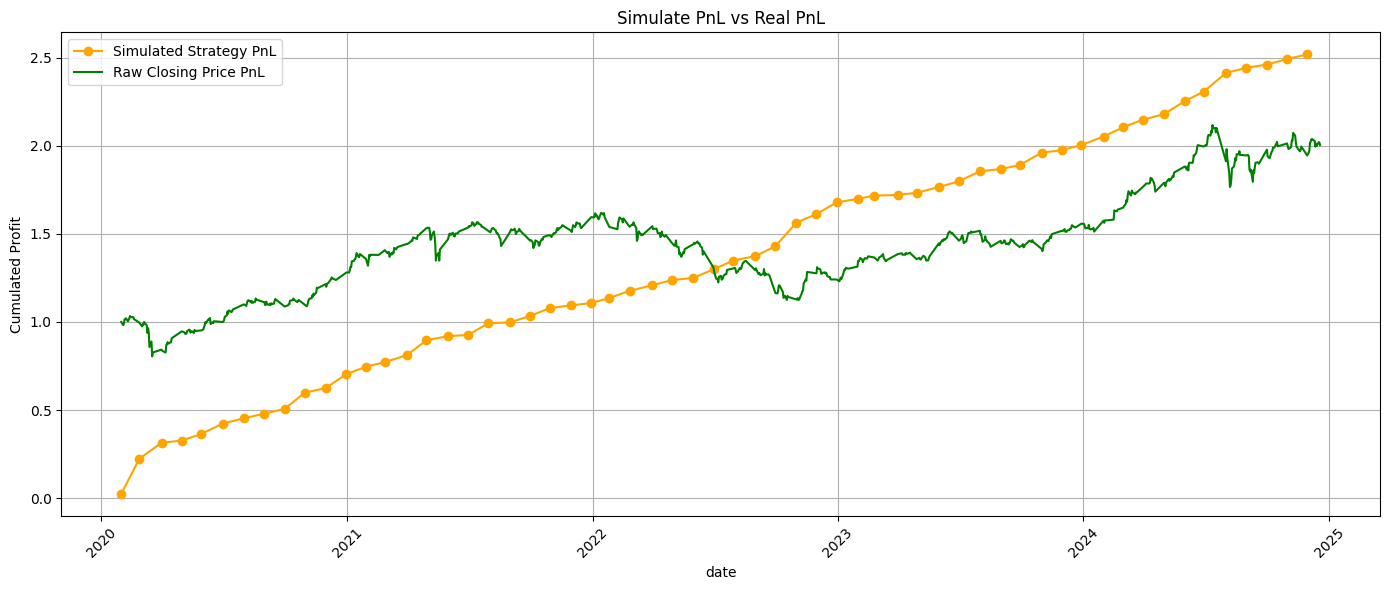

In [8]:
# 🔁 將每段主力合約的收盤價串接起來，作為參考基準線
import matplotlib.pyplot as plt
all_main_data = []

for idx, row in main_contracts.iterrows():
    start, end = row['主力起始日'], row['主力結束日']
    main_id = row['主力代號']
    segment_df = daily_df[(daily_df['交易日期'] >= start) & (daily_df['交易日期'] <= end)]
    main_data = segment_df[segment_df['合約代號'] == main_id][['交易日期', '收盤價']].copy()
    all_main_data.append(main_data)

df_closing = pd.concat(all_main_data).drop_duplicates(subset='交易日期').sort_values('交易日期')
df_closing['報酬率'] = df_closing['收盤價'].pct_change().fillna(0)
df_closing['累積報酬'] = (1 + df_closing['報酬率']).cumprod()

# 原模擬策略的累積報酬資料
simulated_sorted = result_df.sort_values(by='區段起始')
simulated_dates = pd.to_datetime(simulated_sorted['區段起始'])
simulated_pnl = simulated_sorted['淨報酬'].fillna(0).cumsum()

# 📈 畫出比較圖
plt.figure(figsize=(14, 6))
plt.plot(simulated_dates, simulated_pnl, label='Simulated Strategy PnL', color='orange', marker='o')
plt.plot(df_closing['交易日期'], df_closing['累積報酬'], label='Raw Closing Price PnL', color='green')

plt.title('Simulate PnL vs Real PnL')
plt.xlabel('date')
plt.ylabel('Cumulated Profit')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [9]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 如果尚未處理，先轉換方向成數值
result_df['方向數值'] = result_df['方向'].map({'long': 1, 'short': 0})

# 準備資料
model_df = result_df.dropna(subset=['最佳轉倉天數N*', '方向數值', '淨報酬'])

# 特徵與目標
X = model_df[['方向數值', '淨報酬']]
y = model_df['最佳轉倉天數N*']

# 分割資料集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 建立隨機森林回歸模型
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 預測與評估
y_rf_pred = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, y_rf_pred)
rf_r2 = r2_score(y_test, y_rf_pred)

# 顯示特徵重要性
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# 顯示結果
print("Random Forest Regression 結果")
print(feature_importance)
print(f"Test R² Score: {rf_r2:.4f}")
print(f"Test MSE: {rf_mse:.4f}")



Random Forest Regression 結果
  Feature  Importance
1     淨報酬    0.942391
0    方向數值    0.057609
Test R² Score: -1.0320
Test MSE: 14.5063


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 用原始每段報酬作為 returns（直接使用）
# 替代這行（原本是從 result_df 抓資料）
simulated_sorted = result_df.sort_values(by='區段起始')
simulated_dates = pd.to_datetime(simulated_sorted['區段起始'])
returns_series = pd.Series(data=simulated_sorted['淨報酬'].fillna(0).values, index=simulated_dates)


# 清除極端報酬（inf / nan）
returns_series = returns_series.replace([np.inf, -np.inf], np.nan).dropna()

# ➤ 推估年化用的頻率：計算平均每段間隔天數
avg_days_per_segment = simulated_dates.diff().dt.days.dropna().mean()
segments_per_year = 252 / avg_days_per_segment if avg_days_per_segment else 12  # fallback

# ➤ 計算績效指標
avg_return = returns_series.mean()
std_return = returns_series.std()
annual_return = (1 + avg_return) ** segments_per_year - 1
annual_volatility = std_return * np.sqrt(segments_per_year)
sharpe_ratio = annual_return / annual_volatility if annual_volatility != 0 else np.nan

# ➤ 累積報酬與 MDD 計算
cumulative_return = (1 + returns_series).cumprod()
rolling_max = cumulative_return.cummax()
drawdown = (cumulative_return - rolling_max) / rolling_max
max_drawdown = drawdown.min()

# ➤ Recovery days
recovery_days = []
counter = 0
for val in drawdown:
    if val < 0:
        counter += 1
    else:
        if counter > 0:
            recovery_days.append(counter)
        counter = 0
if counter > 0:
    recovery_days.append(counter)
max_recovery_days = max(recovery_days) if recovery_days else 0

# ➤ 輸出表格
summary_df = pd.DataFrame({
    'Annual Return (%)': [annual_return * 100],
    'Annual Volatility': [annual_volatility],
    'Sharpe Ratio': [sharpe_ratio],
    'Max Drawdown': [max_drawdown],
    'Max Recovery Days': [max_recovery_days],
    'Avg Days per Segment': [avg_days_per_segment],
    'Segments per Year': [segments_per_year]
}).round(2)




In [11]:
summary_df


,Annual Return (%),Annual Volatility,Sharpe Ratio,Max Drawdown,Max Recovery Days,Avg Days per Segment,Segments per Year
0,41.41,0.1,4.29,0.0,0,30.41,8.29


In [12]:
result_df.to_csv("最佳轉倉_含多空成本.csv", index=False)

#from google.colab import files
#files.download("最佳轉倉_含多空成本.csv")